In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, tensorflow as tf, os, cv2
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid # for plotting more than 1 graph in grid format
from tqdm import tqdm
tqdm.pandas()
from glob import glob # for regex related operations
import random
from skimage import io
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout, Concatenate, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
data_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

In [4]:
len(os.listdir(data_path))

112

In [5]:
# filenames = os.listdir(data_path)
# print(len(filenames))
# for file in filenames: 
#     print(file)
    
## ------Another way to get list of files------   
for name in glob(data_path + '*'):
    print(name)

/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7694_19950404
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_1991

In [6]:
for file in glob(data_path + '*.csv'):
    print(file)

/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [7]:
for file in glob(data_path + '*.md'):
    print(file)

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md


In [8]:
readme = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
with open(readme, 'r') as f:
    text = f.read()
    print(text)

# LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders na

In [9]:
df = pd.read_csv('/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv')
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [10]:
# len(df['Patient'].values)

In [11]:
df.shape

(110, 18)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [13]:
glob(data_path +"*")

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7694_19950404',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726',
 '/kag

In [14]:
# path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
# path.split('/')[-1]

# os.listdir(path)

In [15]:
# path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512'
# path.split('/')[-1]

# os.listdir(path)

In [16]:
data_map = []
for sub_dir_path in glob(data_path +"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [17]:
# data_map

In [18]:
df_path = pd.DataFrame({'Patient_ID': data_map[::2], 'path': data_map[1::2]})
df_path.head()

,Patient_ID,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [19]:
df_imgs = df_path[~df_path['path'].str.contains('mask')]
df_masks = df_path[df_path['path'].str.contains('mask')]
df_path.head()

,Patient_ID,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [20]:
df_imgs

,Patient_ID,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
7849,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7850,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7852,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [21]:
# df_masks.values[:12]

In [22]:
# df_masks[df_masks['Patient_ID'] == 'TCGA_DU_7010_19860307'].iloc[0][1]

In [23]:
df_path.shape, df_imgs.shape, df_masks.shape

((7858, 2), (3929, 2), (3929, 2))

In [24]:
# len("/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif")

In [25]:
df_imgs['path'].values

array(['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif',
       ...,
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_2.tif'],
      dtype=object)

In [26]:
# len("/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43.tif")

In [27]:
# ank = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif'
# len(ank)

In [28]:
# ank[89:-4]

In [29]:
# df_imgs['path'].values[0]

In [30]:
# df_masks['path'].values[0]

In [31]:
# ank2 = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif'

In [32]:
# print(ank2[89:-9])
# print(type(int(ank2[89:-9])))
# print(type(ank2[89:-9]))

In [33]:
# func = lambda x: int(x[89:-4])
# print(func(df_imgs['path'].values[0]))

In [34]:
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_<-!!!43.tif) length of the path string upto "TCGA_DU_6404_19850629_" this
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif) length of the ".tif" part
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif) length of the "_mask.tif" part

In [35]:
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# checking the sorted list
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_24.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_24_mask.tif


In [36]:
# Final dataframe

df_brain = pd.DataFrame({'Patient_ID': df_imgs['Patient_ID'], 'img_path': imgs, 'mask_path': masks})
df_brain

,Patient_ID,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
7849,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7850,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7852,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [37]:
# function to check whether there is a cancer 

def pos_neg_diagnosis(mask_path):
    value = np.argmax(cv2.imread(mask_path))
    if value>0: 
        return 1 # pixel value>0 in mask so, it is a bright pixel and hence cancer is present(i.e. True or 1)
    else:
        return 0

df_brain['mask'] = df_brain['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
df_brain

,Patient_ID,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
5,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
7849,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
7850,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
7852,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [38]:
df_brain[df_brain['mask']==1].sort_index()

,Patient_ID,img_path,mask_path,mask
1073,TCGA_DU_7300_19910814,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1078,TCGA_DU_7300_19910814,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1123,TCGA_DU_7018_19911220,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1145,TCGA_DU_7018_19911220,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1240,TCGA_DU_7301_19911112,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
...,...,...,...,...
7554,TCGA_DU_A5TU_19980312,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
7582,TCGA_HT_A616_19991226,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
7583,TCGA_HT_A616_19991226,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
7604,TCGA_HT_A616_19991226,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


In [39]:
# cv2.imread(df_brain.mask_path[i]).max()

In [40]:
df_brain['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

<Axes: >

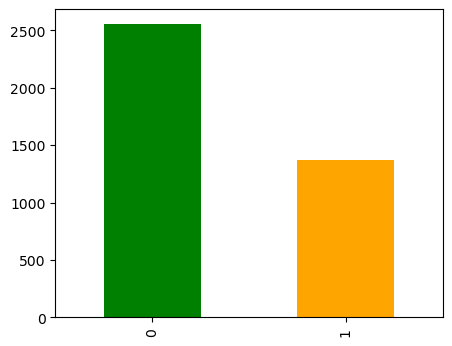

In [41]:
plt.figure(figsize = (5,4))
df_brain['mask'].value_counts().plot(kind = 'bar', color = ['green', 'orange'])

In [42]:
df_brain.iloc[537]

Patient_ID                                TCGA_DU_7300_19910814
img_path      /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
mask_path     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
mask                                                          1
Name: 1073, dtype: object

In [43]:
len(df_brain)

3929

In [44]:
cv2.imread(df_brain['mask_path'].iloc[537]).max()

255

537


Text(0.5, 1.0, 'Brain MRI')

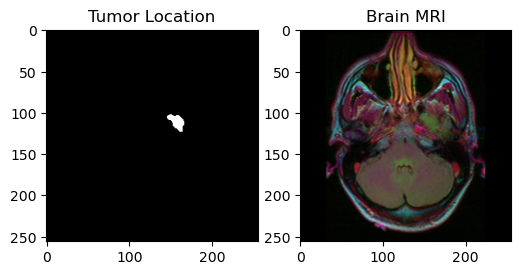

In [45]:
for i in range(len(df_brain)):
    if cv2.imread(df_brain['mask_path'].iloc[i]).max() > 0:
        print(i)
        break

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df_brain.mask_path.iloc[i]))
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df_brain.img_path.iloc[i]))
plt.title('Brain MRI')

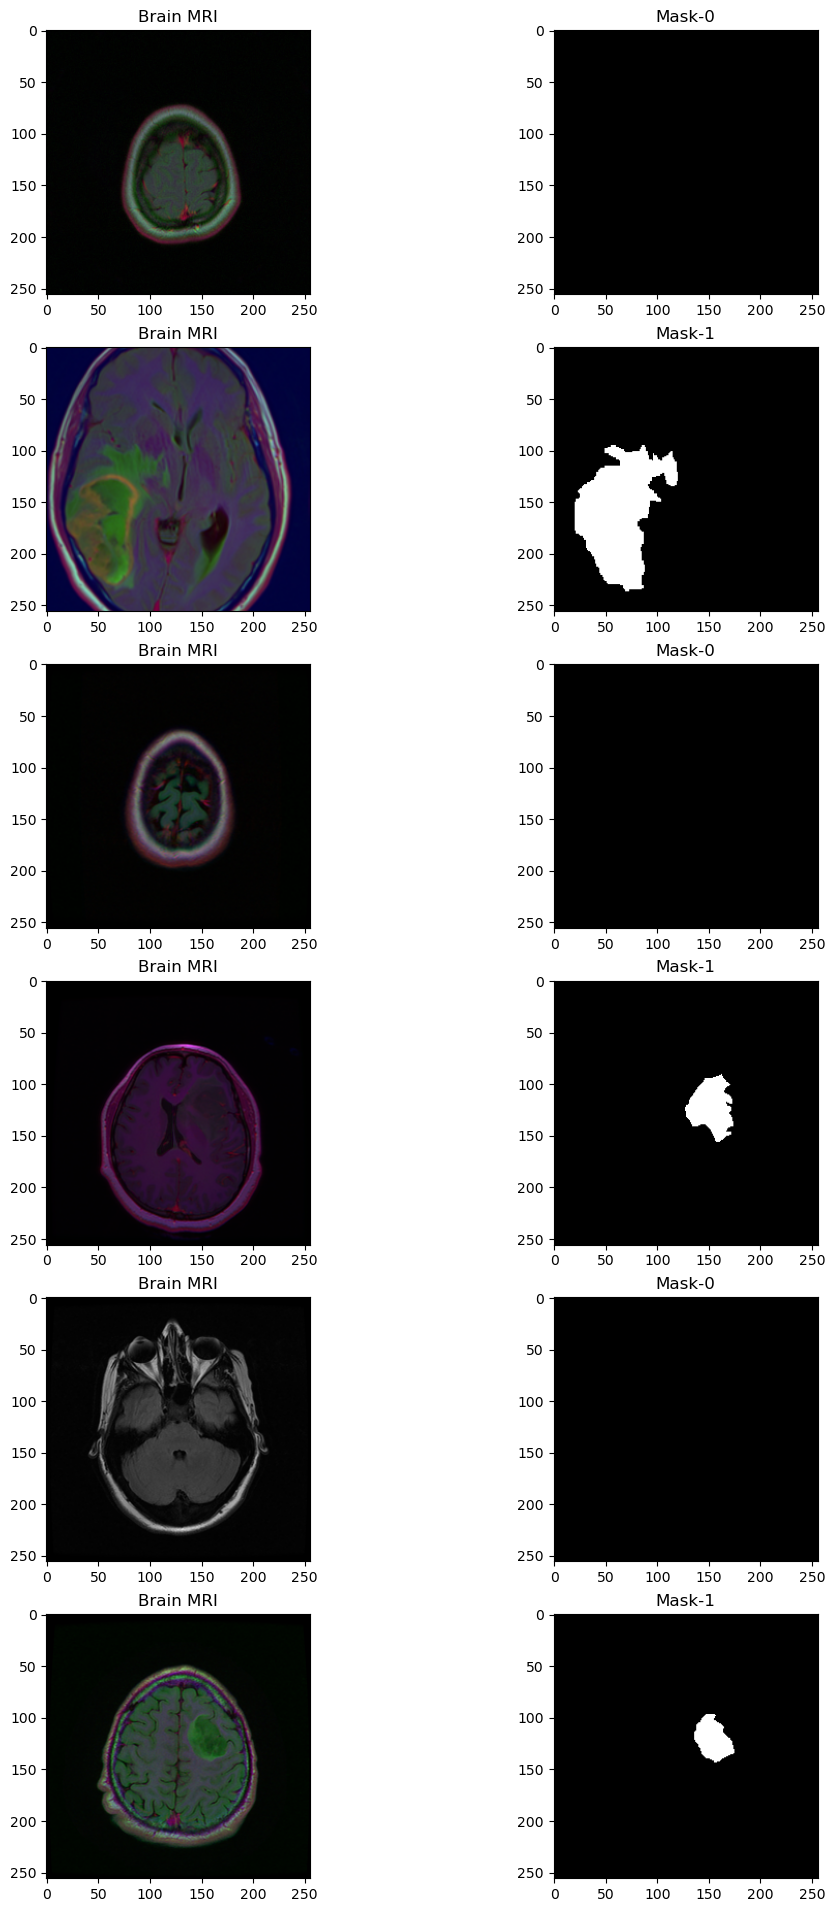

In [46]:
# ploting mri scans and their corresponding mask
fig, axs = plt.subplots(6,2, figsize = (12,24))
for x in range(6):
    i = random.randint(0,len(df_brain)-1)
    axs[x][0].imshow(cv2.imread(df_brain.img_path.iloc[i]))
    axs[x][0].title.set_text('Brain MRI')
    
    axs[x][1].imshow(cv2.imread(df_brain.mask_path.iloc[i]))
    axs[x][1].title.set_text('Mask-' + str(df_brain['mask'].iloc[i]))

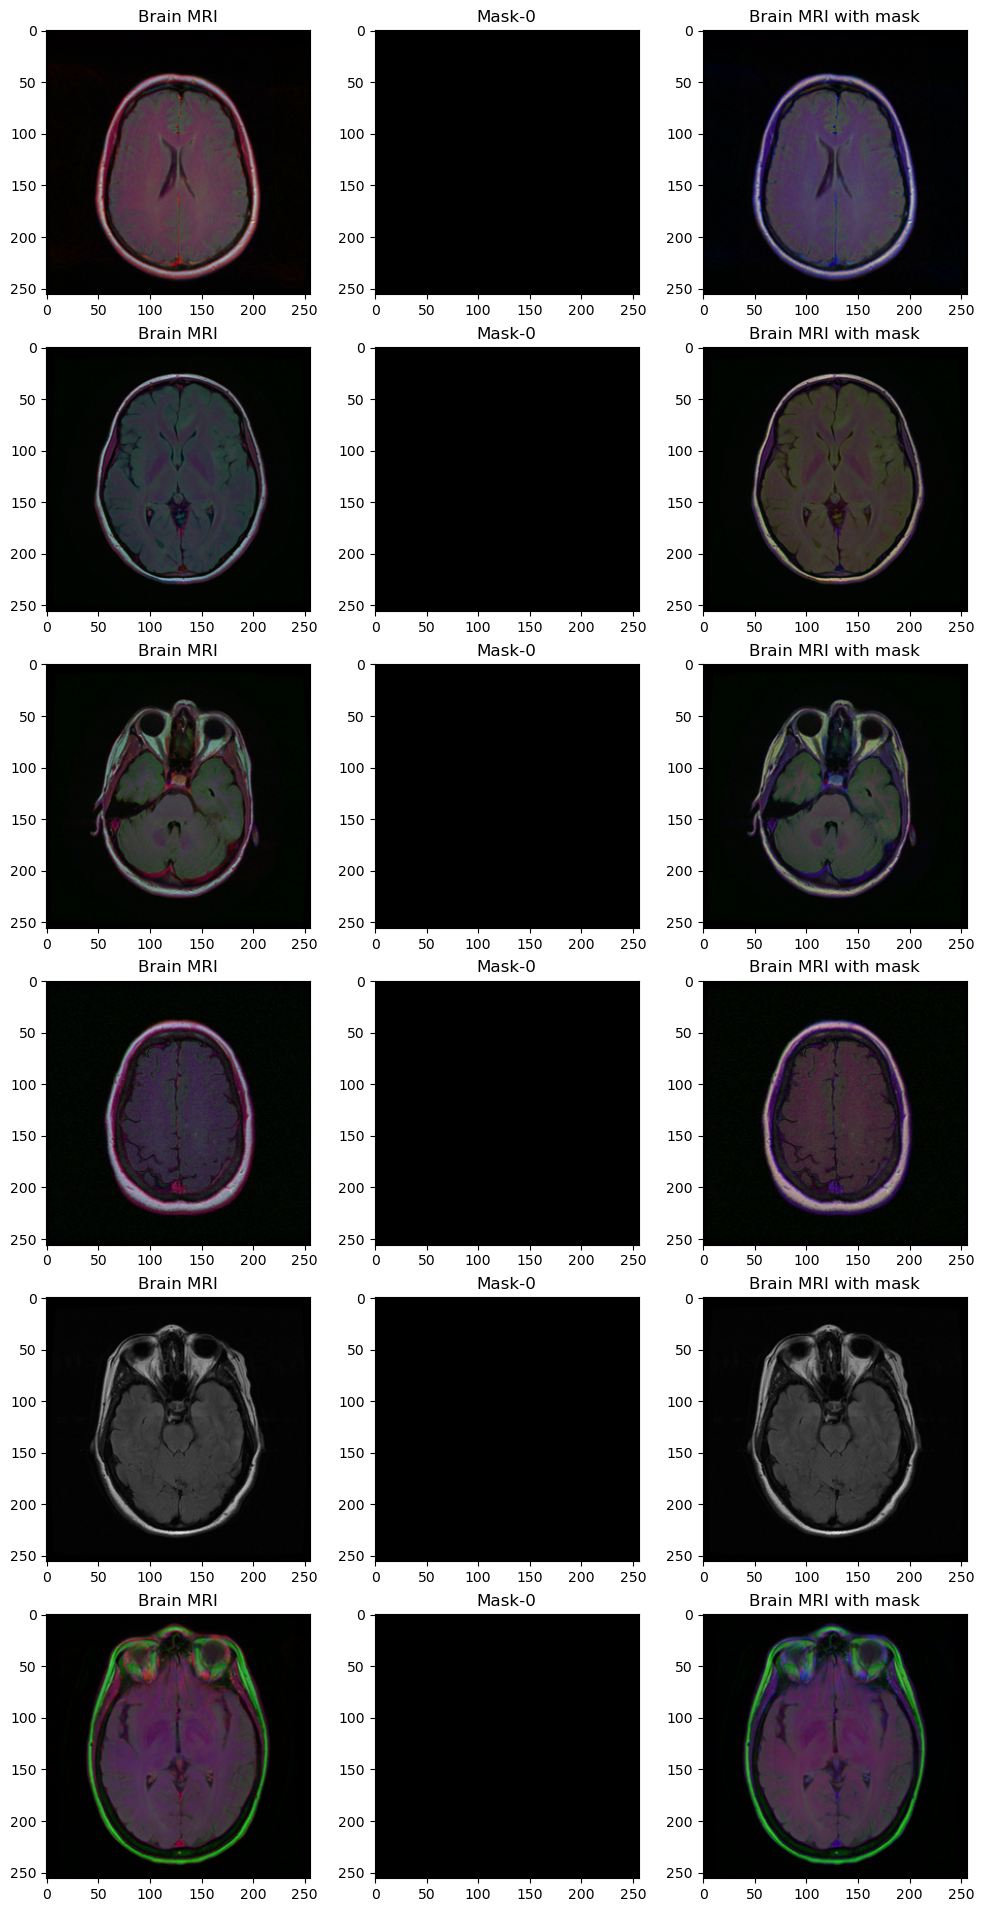

In [47]:
# ploting mri scans with mask and super-imposing the mask over the mri scan image
fig, axs = plt.subplots(6,3, figsize = (12,24))
for x in range(6):
    i = random.randint(0,len(df_brain)-1)
    # print(i)  -- to know the index of the image
    img = io.imread(df_brain.img_path.iloc[i])
    axs[x][0].imshow(cv2.imread(df_brain.img_path.iloc[i]))
    axs[x][0].title.set_text('Brain MRI')
    
    mask = io.imread(df_brain.mask_path.iloc[i])
    axs[x][1].imshow(cv2.imread(df_brain.mask_path.iloc[i]))
    axs[x][1].title.set_text('Mask-' + str(df_brain['mask'].iloc[i]))
    
    img[mask == 255] = (0, 255, 150)
    axs[x][2].imshow(img)
    axs[x][2].title.set_text('Brain MRI with mask')

### Splitting the dataset into train and validation set

In [48]:
df_brain_train = df_brain.drop('Patient_ID', axis = 1)
df_brain_train.head()

,img_path,mask_path,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
5,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [49]:
# changing the data type of values in mask column from str to int to set class_mode in flow_from_directory to categorical
df_brain_train['mask'] = df_brain_train['mask'].apply(lambda x: str(x))

In [50]:
df_brain_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3929 entries, 0 to 7856
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   3929 non-null   object
 1   mask_path  3929 non-null   object
 2   mask       3929 non-null   object
dtypes: object(3)
memory usage: 122.8+ KB


In [51]:
train, test = train_test_split(df_brain_train, test_size = 0.33)

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=0.1, 
                             zoom_range = 0.2,
                            horizontal_flip = True, 
                            rotation_range = 10, 
                             fill_mode = 'nearest',
                            width_shift_range = 0.2, 
                             height_shift_range=0.2)

train_generator = datagen.flow_from_dataframe(train,
                                              x_col='img_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256))

valid_generator = datagen.flow_from_dataframe(train,
                                              x_col='img_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256))

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  x_col='img_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  target_size=(256,256))

Found 2369 validated image filenames belonging to 2 classes.
Found 263 validated image filenames belonging to 2 classes.
Found 1297 validated image filenames belonging to 2 classes.


In [53]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
# clf_model.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [54]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# model.summary()

In [55]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10)

checkpointer = ModelCheckpoint('/kaggle/working/Rsnt_MRI.hdf5',
                                save_best_only=True, 
                                save_weights_only=False, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2)
csvlogger = CSVLogger(('/kaggle/working/Rsnt_MRI.csv'))

callbacks = [checkpointer, earlystopping, reduce_lr, csvlogger]

In [56]:
train_generator.n

2369

In [57]:
train_generator.batch_size

32

## Classification 

In [58]:
# history_rsnt = model.fit(train_generator, 
#               steps_per_epoch= train_generator.n // train_generator.batch_size, 
#               epochs = 20, 
#               validation_data= valid_generator, 
#               validation_steps= valid_generator.n // valid_generator.batch_size, 
#               callbacks=[checkpointer, earlystopping, csvlogger])

In [59]:
rsnt_mri = tf.keras.models.load_model('/kaggle/input/rsnt-brain-mri-ankush-2/Rsnt_MRI.hdf5')

In [60]:
_, acc = rsnt_mri.evaluate(test_generator)
print("Test generator: {} %".format(acc*100))

41/41 [==============================] - 26s 318ms/step - loss: 0.2226 - accuracy: 0.9136
Test generator: 91.36468768119812 %


In [61]:
history_csv = pd.read_csv("/kaggle/input/rsnt-brain-mri-ankush-2/Rsnt_MRI.csv")
history_csv.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.722294,0.775025,0.332031,26692.853516
1,1,0.719298,0.624521,0.328125,64.149353
2,2,0.757809,0.464049,0.675781,0.674622
3,3,0.813008,0.388138,0.664062,0.646555
4,4,0.838682,0.359239,0.671875,0.631054


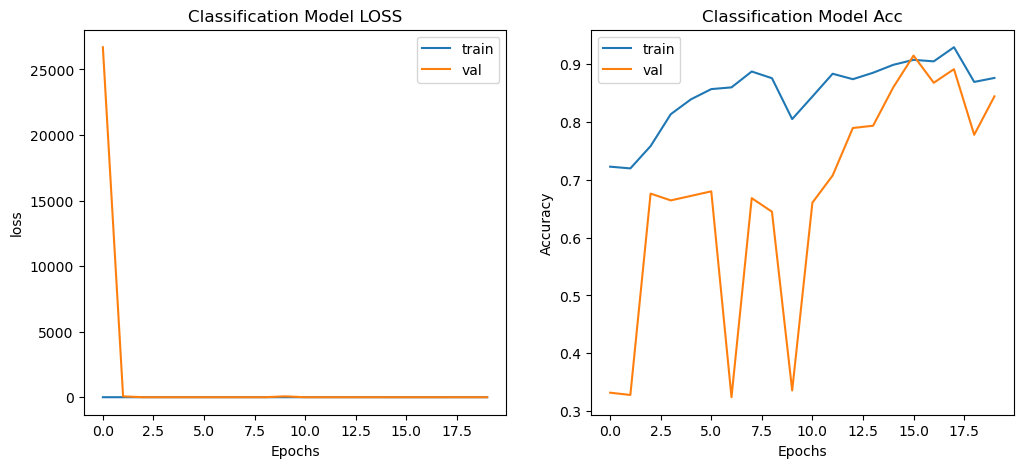

In [62]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_csv['loss']);
plt.plot(history_csv['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_csv['accuracy']);
plt.plot(history_csv['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

41/41 [==============================] - 6s 128ms/step
0.9136468774094063


<Axes: >

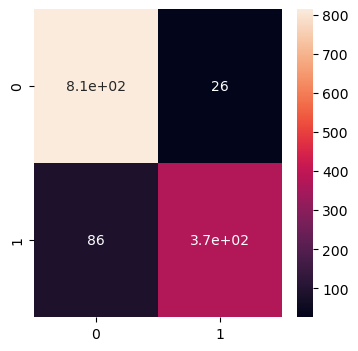

In [63]:
prediction = rsnt_mri.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

plt.figure(figsize=(4,4))
cm = confusion_matrix(original, pred)
sns.heatmap(cm, annot=True)

In [64]:
report = classification_report(original, pred, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       840
           1       0.93      0.81      0.87       457

    accuracy                           0.91      1297
   macro avg       0.92      0.89      0.90      1297
weighted avg       0.92      0.91      0.91      1297



In [65]:
prediction

array([[9.9015266e-01, 9.8473681e-03],
       [4.0844190e-01, 5.9155804e-01],
       [9.9921978e-01, 7.8019983e-04],
       ...,
       [9.9843031e-01, 1.5697158e-03],
       [9.9998188e-01, 1.8137704e-05],
       [7.8160715e-01, 2.1839291e-01]], dtype=float32)

In [66]:
value = np.argmax(prediction, axis = 1)
value

array([0, 1, 0, ..., 0, 0, 0])

In [67]:
value.shape

(1297,)

In [68]:
prediction.shape

(1297, 2)

## Segmentation 

In [69]:
df_brain.head()

,Patient_ID,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
5,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [70]:
df_brain_mask = df_brain[df_brain["mask"]== 1]
# df_brain_mask.head()
print(df_brain_mask.shape)

(1373, 4)


In [71]:
## splitting the dataset into test, train and validation for segmentation task

X_train, X_val = train_test_split(df_brain_mask, test_size = 0.2)
X_test, X_val = train_test_split(X_val, test_size = 0.5)
print("The shape of X_train is {}, X_test is {} and X_val is {}.".format(len(X_train), len(X_test), len(X_val)))

The shape of X_train is 1098, X_test is 137 and X_val is 138.


In [72]:
# list(X_train["img_path"])

In [73]:
## making list of paths of images and masks of X_train and X_val 
train_img = list(X_train["img_path"])
train_mask = list(X_train["mask_path"])

val_img = list(X_val["img_path"])
val_mask = list(X_val["mask_path"])

In [74]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, img, mask, img_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):
        self.img = img
        self.mask = mask
        self.img_dir = img_dir
        self.batch_size = batch_size 
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        '''To get the number of batches of images per epoch'''
        return len(self.img)//self.batch_size
    
    def __getitem__(self, index):
        '''To get the batch of images'''
        
        #generate index of batch_size length
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        #get the ImageId corresponding to the indexes created above based on batch size
        list_img = [self.img[i] for i in indexes]
        
        #get the MaskId corresponding to the indexes created above based on batch size
        list_mask = [self.mask[i] for i in indexes]
        
        #get the generated images for X and y
        X, y = self.__data_generation(list_img, list_mask)
        
        return X, y
    
    def on_epoch_end(self):
        '''To shuffle the indexes at the end of the epoch'''
        
        #getting the array of indices based on the input dataframe
        self.indexes = np.arange(len(self.img))
        
        #if shuffle is true, shuffle the indices
        if self.shuffle:
          np.random.shuffle(self.indexes)
        
    def __data_generation(self, list_img, list_mask):
        '''generate the data corresponding the indexes in a given batch of images'''
    
        #create empty array of images and masks of shape (batch_size,height,width,depth) 
        #depth of array of images is 3 and that of masks array is 1 as masks are either white or black so only a single channel
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        
        for i in range(len(list_img)):
            #getting path of the image and reading the image
            img_path = str(list_img[i])
            img = io.imread(img_path)
            
            #getting path of the mask and reading the mask image
            mask_path = str(list_mask[i])
            mask = io.imread(mask_path)
            
            #resizing and coverting image and its mask to array of type float64
            img = cv2.resize(img,(self.img_h,self.img_w))
            img = np.array(img, dtype = np.float64)
      
            mask = cv2.resize(mask,(self.img_h,self.img_w))
            mask = np.array(mask, dtype = np.float64)
            
            #standardising 
            img -= img.mean()
            img /= img.std()
      
            mask -= mask.mean()
            mask /= mask.std()
            
            #Adding image to the empty array
            X[i,] = img
            #expanding the dimnesion of the image from (256,256) to (256,256,1)
            y[i,] = np.expand_dims(mask, axis = 2)
    
            #normalizing y(all values of y between 0 and 1)
            y = (y > 0).astype(int) #--> convert 1.1, 1.5, 1.9 to 1 basically remove the decimal part 

        return X, y

In [75]:
train_data = CustomDataGen(train_img, train_mask)
val_data = CustomDataGen(val_img, val_mask)

In [76]:
# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding = 'same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     x = Conv2D(num_filters, 3, padding = 'same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     return x

# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = 'same')(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_resnet50_unet(input_shape):
#     """Input"""
#     inputs = Input(input_shape)
    
#     """Pre-trained ResNet50 model"""
#     resnet50 = ResNet50(include_top = False, weights = 'imagenet', input_tensor = inputs)
# #     resnet50.summary()
    
#     """Encoder"""
#     s1 = resnet50.get_layer("input_17").output  ## 256
#     s2 = resnet50.get_layer("conv1_relu").output  ## 128
#     s3 = resnet50.get_layer("conv2_block3_out").output ## 64
#     s4 = resnet50.get_layer("conv3_block4_out").output ## 32
    
# #     print(s1.shape, s2.shape, s3.shape, s4.shape)

#     """Bridge"""
#     b1 = resnet50.get_layer("conv4_block6_out").output ## 16
    
#     """Decoder"""
#     d1 = resnet50.get_layer(b1, s4, 256) ## 32
#     d2 = resnet50.get_layer(d1, s3, 128).output  ## 64
#     d3 = resnet50.get_layer(d2, s2, 64).output ## 128
#     d4 = resnet50.get_layer(d3, s1, 32).output ## 256
    
#     """Outputs"""
#     outputs = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)
    
#     model = Models(inputs, outputs)
#     return model
    
# if __name__ == "__main__":
#     input_shape = (256, 256, 3)
#     model_seg = build_resnet50_unet(input_shape)
#     model.summary()

In [77]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Concatenate()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [78]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

model_seg = Model(X_input, out)
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [121]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
import tensorflow.keras.backend as K
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [122]:
#compile the model
opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001,decay=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model_seg.compile(optimizer = opt, loss = focal_tversky, metrics = [tversky])

# callbacks
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10)

checkpointer = ModelCheckpoint('/kaggle/working/Rsnt_MRI_segmentation.hdf5',
                                save_best_only=True, 
                                save_weights_only=False, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2)
csvlogger = CSVLogger(('/kaggle/working/Rsnt_MRI_segmentation.csv'))

callbacks = [checkpointer, earlystopping, reduce_lr, csvlogger]

In [81]:
# history_seg = model_seg.fit(train_data, 
#               epochs = 20, 
#               validation_data= val_data, 
#               callbacks=[checkpointer, earlystopping, csvlogger])

In [123]:
# load segmentation model 
model_seg = tf.keras.models.load_model('/kaggle/input/rsnt-brain-mri-ankush/Rsnt_MRI_segmentation.hdf5')

ValueError: Unknown loss function: 'focal_tversky'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

## Creating a pipeline network of classification and segmentation

Here, I am creating a combination of classification followed by segmentation model. First, an image is passed through the classification model and it predicts whether a tumour is present in the image. If tumour is not present, the loop continues but if there is a tumour then the image is passed to the segmentation model and this segmentation model again looks whether tumour is present in the image. 

In [83]:
# def prediction(test, model, model_seg):
#      # empty list to store results
#     mask, image_id, has_mask = [], [], []
    
#     #itetrating through each image in test data
#     for i in test.img_path:
        
#         img = io.imread(i)
#         #normalizing
#         img = img *1./255.
#         #reshaping
#         img = cv2.resize(img, (256,256))
#         # converting img into array
#         img = np.array(img, dtype=np.float64)
#         #reshaping the image from 256,256,3 to 1,256,256,3
#         img = np.reshape(img, (1,256,256,3))
        
#         #making prediction for tumor in image
#         is_defect = model.predict(img)
        
#         #if tumour is not present we append the details of the image to the list
#         if np.argmax(is_defect)==0:
#             image_id.append(i)
#             has_mask.append(0)
#             mask.append('No mask :)')
#             continue
        
#         #Creating a empty array of shape 1,256,256,1
#         X = np.empty((1,256,256,3))
#         # read the image
#         img = io.imread(i)
#         #resizing the image and coverting them to array of type float64
#         img = cv2.resize(img, (256,256))
#         img = np.array(img, dtype=np.float64)
        
#         # standardising the image
#         img -= img.mean()
#         img /= img.std()
#         #converting the shape of image from 256,256,3 to 1,256,256,3
#         X[0,] = img
        
#         #make prediction of mask
#         predict = model_seg.predict(X)
        
#         # if sum of predicted mask is 0 then there is not tumour
#         if predict.round().astype(int).sum()==0:
#             image_id.append(i)
#             has_mask.append(0)
#             mask.append('No mask :)')
#         else:
#         #if the sum of pixel values are more than 0, then there is tumour
#             image_id.append(i)
#             has_mask.append(1)
#             mask.append(predict)
            
#     return pd.DataFrame({'img_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [84]:
# def prediction(test, model, model_seg):
#     # empty lists to store the results
#     image_id = [] # to store the image path
#     mask = [] # either "No mask" if predicted value is zero otherwise predicted values of mask if prediction is non-zero
#     has_mask = [] # store 1 if tumour is present and 0 is not present
    
#     for i in test.img_path: 
#         #reading the image
#         img = io.imread(i) 
#         #normalizing
#         img = img*(1./255)
#         #reshaping
#         img = cv2.resize(img, (256, 256))
#         #converting img into array
#         #img = np.array(img, dtype = np.float64)
#         #reshaping the image from (256, 256, 3) to (1, 256, 256, 3) 
#         img = np.reshape(img, (1, 256, 256, 3)) # this is because our model accept inputs in this format (batch_size, image_height, image_width, n_channels)
        
        
#         # making predictions for tumour in image using classification
#         pred_class = model.predict(img)
        
#         #if tumour is not present we will append the details of the image to the lists
#         if(np.argmax(pred_class)==0):
#             image_id.append(i)
#             mask.append("No mask")
#             has_mask.append(0)
#             continue
            
#         # now, if image is having tumour as per the classification model then we will pass the image to the segmentation model
        
#         #Creating a empty array of shape 1,256,256,1
#         X = np.empty((1,256,256,3))
        
#         #standardising the image
#         img-=img.mean()
#         img/=img.std()
        
#         #converting the shape of image from 256,256,3 to 1,256,256,3
#         X[0,] = img
        
#         # making mask prediction using segmentation model
#         pred_seg = model_seg.predict(X)
        
#         if(np.argmax(pred_seg)==0): # if argmax is zero, means that tumour is not present
#             image_id.append(i)
#             mask.append("No mask")
#             has_mask.append(0)
#         else: 
#             image_id.append(i)
#             mask.append(pred_seg)
#             has_mask.append(1)
            
#     return pd.DataFrame({"img_path": image_id, "predicted_mask": mask, "has_mask": has_mask})

In [85]:
# test_img = list(X_test["img_path"])
# test_mask = list(X_test["mask_path"])
# test_data = CustomDataGen(test_img, test_mask)

In [86]:
# _, tv = model_seg.evaluate(test_data)
# print("Accruacy: {}".format(tv*100))

In [87]:
# df_pred_final = prediction(test, rsnt_mri, model_seg)
# df_pred_final.head()

In [88]:
# test.head()

In [89]:
# df_pred = test.merge(df_pred_final, on = 'img_path')
# df_pred.head()

In [90]:
# df_pred[df_pred.has_mask==1].head()

In [91]:
# df_pred.img_path[0]

In [92]:
# # ploting mri scans and their corresponding mask
# fig, axs = plt.subplots(6,2, figsize = (12,24))
# for x in range(6):
#     i = random.randint(0,len(df_brain)-1)
#     axs[x][0].imshow(cv2.imread(df_brain.img_path.iloc[i]))
#     axs[x][0].title.set_text('Brain MRI')
    
#     axs[x][1].imshow(cv2.imread(df_brain.mask_path.iloc[i]))
#     axs[x][1].title.set_text('Mask-' + str(df_brain['mask'].iloc[i]))

In [93]:
# df_pred.predicted_mask[1].shape

In [94]:
# df_pred.predicted_mask[1]

In [95]:
# np.array(df_pred.predicted_mask[1]).squeeze().shape

In [96]:
# ak = io.imread(df_pred.mask_path[1])
# # plt.imshow(ak)
# ak.shape

In [97]:
# pred = np.array(df_pred.predicted_mask[1]).round()
# pred, pred.shape

In [98]:
# count = 0   
# fig, axs = plt.subplots(5,5, figsize=(30,70))
# for i in range(len(df_pred)):
#     if df_pred.has_mask[i]==1 and count<5:
#         #read mri images
#         img = io.imread(df_pred.img_path[i])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         axs[count][0].imshow(img)
#         axs[count][0].title.set_text('Brain MRI')
        
#         #read original mask
#         mask = io.imread(df_pred.mask_path[i])
#         axs[count][1].imshow(mask)
#         axs[count][1].title.set_text('Original Mask')
        
#         #read predicted mask
#         pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
# #         pred = pred.reshape(2)
#         axs[count][2].imshow(pred)
#         axs[count][2].title.set_text('AI predicted mask')
        
#         count +=1
#     if (count==5):
#         break

# fig.tight_layout() 

In [99]:
# #visualizing prediction
# count = 0   
# fig, axs = plt.subplots(15,5, figsize=(30,70))

# for i in range(len(df_pred)):
#     if df_pred.has_mask[i]==1 and count<15:
#         #read mri images
#         img = io.imread(df_pred.img_path[i])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         axs[count][0].imshow(img)
#         axs[count][0].title.set_text('Brain MRI')
        
#         #read original mask
#         mask = io.imread(df_pred.mask_path[i])
#         axs[count][1].imshow(mask)
#         axs[count][1].title.set_text('Original Mask')
        
#         #read predicted mask
#         pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
#         axs[count][2].imshow(pred)
#         axs[count][2].title.set_text('AI predicted mask')
        
#         #overlay original mask with MRI
#         img[mask==255] = (255,0,0)
#         axs[count][3].imshow(img)
#         axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
#         #overlay predicted mask and MRI
#         img_ = io.imread(df_pred.img_path[i])
#         img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
#         img_[pred==1] = (0,255,150)
#         axs[count][4].imshow(img_)
#         axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
#         count +=1
#     if (count==15):
#         break

# fig.tight_layout() 

In [100]:
# df_imgs.head()

In [101]:
# l.shape, img1.shape

In [102]:
# l.dtype, l1.dtype, l_temp.dtype

In [103]:
# l1.mean()

In [104]:
# def standardize(img):
#     img-=img.mean()
#     img/=img.std()
#     return img

In [105]:
# l1.shape

In [106]:
# plt.imshow(l_temp)

In [107]:
# plt.imshow(img1)

In [108]:
# ar = standardize(l_temp)
# plt.imshow(ar)

In [109]:
# img = df_imgs['path'].iloc[0]
# img1 = io.imread(img)
# # l = np.argmax(img1, axis = 1)
# l_temp = img1*(1./255)
# # l1 = np.array(l_temp, dtype = np.float64)
# l_temp

In [110]:
# img_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'

We can use two methods to read tif format images: 1) Using rasterio library 2) Using cv2 library.
Rasterio is faster than cv2 method.
> **Rasterio:** 31.4 ms ± 400 µs per loop 
> **cv2:** 64.8 ms ± 286 µs per loop

### Using the rasterio library

In [111]:
# import rasterio
# from rasterio.plot import show
# from torchvision.transforms import ToTensor

# with rasterio.open(img_path) as image:
#     image_array = image.read()
#     show(image_array)

In [112]:
# rasterio_img = rasterio.open(img_path)
# show(rasterio_img)

In [113]:
# img_tensor = ToTensor()(image_array)
# img_tensor.shape

### Using cv2 library

In [114]:
# cv2_img = cv2.imread(img_path)
# plt.imshow(cv2_img)

In [115]:
# cv2_img.shape

In [116]:
# img_path

In [117]:
# mask_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'
# cv2_img_mask = cv2.imread(mask_path)
# plt.imshow(cv2_img_mask)

In [118]:
# df.columns